# Pleiades Work-Precision Diagrams

https://benchmarks.sciml.ai/html/NonStiffODE/Pleiades_wpd.html

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using DoubleFloats

In [3]:
f = (du,u,p,t) -> begin
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  v = view(u,15:21) # x′
  w = view(u,22:28) # y′
  du[1:7] .= v
  du[8:14].= w
 # for i in 14:28
  for i in 15:28
    du[i] = zero(u[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      du[14+i] += j*(x[j] - x[i])/r
      du[21+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

prob = ODEProblem(f,[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0],
                 (0.0,3.0));


## Vern9

In [5]:
probDouble64 = ODEProblem(f,Double64.([3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0]),
                     (Double64(0.0),Double64(3.0)));
(typeof(probDouble64.u0),typeof(probDouble64.tspan))

(Array{Double64,1}, Tuple{Double64,Double64})

In [6]:
sol = @time (solve(probDouble64,Vern9(),abstol=1/10^18,reltol=1/10^18,maxiters=1000000))
test_sol = TestSolution(sol);

 87.624113 seconds (95.39 M allocations: 4.010 GiB, 2.69% gc time)


In [7]:
plot(sol)

## IRKGL16

In [9]:
(sol1,iters1,steps1) = @time(solve(prob,IRKGL16(),reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

  0.047699 seconds (42.40 k allocations: 2.285 MiB)


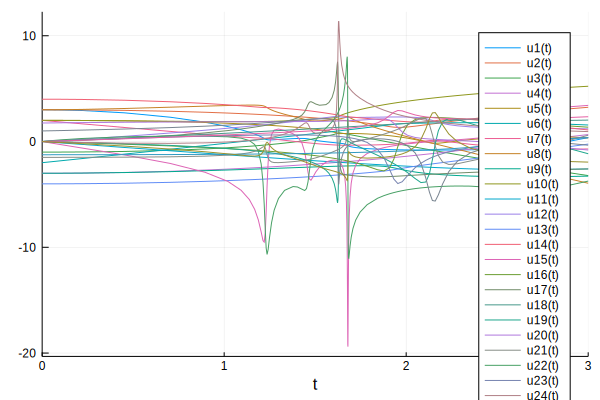

In [10]:
plot(sol1)

## Energy Error

In [11]:
u0128=Double64.(prob.u0)
Gm=Double64.([1,2,3,4,5,6,7])
(typeof(u0128),typeof(Gm),length(Gm))

(Array{Double64,1}, Array{Double64,1}, 7)

In [12]:
function NbodyEnergy(u, Gm)
"""    
     Nbody problem Hamiltonian (Cartesian Coordinates)     
"""    
    
    # Declarations 
    
    dim=2   
    nbody=length(Gm)
    
    # Implementation

 @inbounds begin
    x = view(u,1:7)   # x
    y = view(u,8:14)  # y
    v = view(u,15:21) # x′
    w = view(u,22:28) # y′
   
    H=0.
    P=0.
    
    for i in 1:nbody
        H+=Gm[i]*(v[i]*v[i]+w[i]*w[i])                       
        for j in i+1:nbody           
            r = ((x[i]-x[j])^2+(y[i]-y[j])^2)^(1/2)
            P+=(Gm[i]/r)*Gm[j]
        end
    end
    
    return(H/2-P)
    end
        
end

NbodyEnergy (generic function with 1 method)

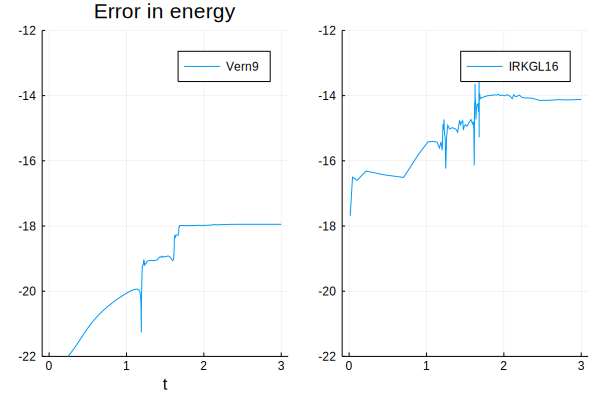

In [16]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol.u
tlist = sol.t
EnergyErrors=[NbodyEnergy(Double64.(sol.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(Double64.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ylimit1=-22
ylimit2=-12

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16")
plot(p1,p2,layout=2)

In [15]:
(maximum(EnergyErrors),maximum(EnergyErrors1))

(1.1309495283721083e-18, 2.7592484945867052e-14)

## Global error

In [17]:
norm(sol1.u[end]-sol.u[end])

6.94849130095921e-13

In [18]:
#
#  Wanner's reference solution 
#
x1 = parse(Double64,"0.370613914397051290093")
x2 = parse(Double64,"3.237284092057233092803")
x3 = parse(Double64,"-3.222559032418323347100")
x4 = parse(Double64,"0.6597091455775308359349")
x5 = parse(Double64,"0.3425581707156579790377")
x6 = parse(Double64,"1.562172101400631016045")
x7 = parse(Double64,"-0.7003092922212495385147")

y1 = parse(Double64,"-3.943437585517392055277")
y2 = parse(Double64,"-3.271380973972549928020")
y3 = parse(Double64,"5.225081843456544192438")
y4 = parse(Double64,"-2.590612434977469510811")
y5 = parse(Double64,"1.198213693392274637514")
y6 = parse(Double64,"-0.2429682344935823409161")
y7 = parse(Double64,"1.091449240428979747882")

v1 = parse(Double64,"3.417003806314314752291")
v2 = parse(Double64,"1.354584501625501221476")
v3 = parse(Double64,"-2.590065597810775419618")
v4 = parse(Double64,"2.025053734714241106485")
v5 = parse(Double64,"-1.155815100160449092711")
v6 = parse(Double64,"-0.8072988170223021725659")
v7 = parse(Double64,"0.5952396354208718766607")
                
w1 = parse(Double64,"-3.741244961234008471204")
w2 = parse(Double64,"0.3773459685750629036558")
w3 = parse(Double64,"0.9386858869551078886946")
w4 = parse(Double64,"0.3667922227200569866696")
w5 = parse(Double64,"-0.3474046353808494366007")
w6 = parse(Double64,"2.344915448180936923142")
w7 = parse(Double64,"-1.947020434263291900674") 

uu=[x1,x2,x3,x4,x5,x6,x7,
    y1,y2,y3,y4,y5,y6,y7,
    v1,v2,v3,v4,v5,v6,v7,
    w1,w2,w3,w4,w5,w6,w7
];

In [19]:
(norm(uu-sol.u[end]),norm(uu-sol1.u[end]))

(1.2606574179075289e-17, 6.948559940483993e-13)

## High Order


In [25]:
abstols = 1.0 ./ 10.0 .^ (13:16)
reltols = 1.0 ./ 10.0 .^ (13:16)

4-element Array{Float64,1}:
 1.0e-13
 1.0e-14
 1.0e-15
 1.0e-16

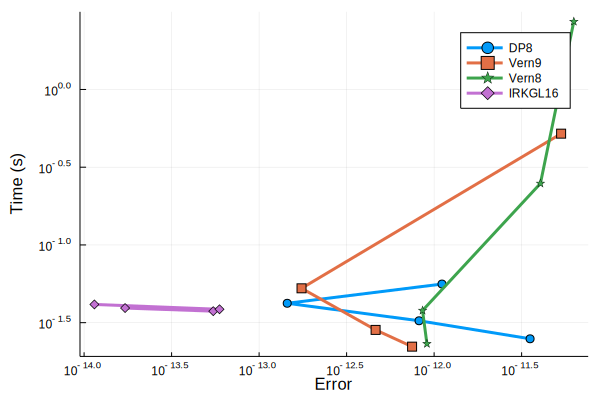

In [26]:
setups = [Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
          Dict(:alg=>Vern8())
          Dict(:alg=>IRKGL16())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100,maxiters=100000)
plot(wp)